# 06. PyTorch Transfer learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problems.

- Pretrained model = foundation models

| Type      | Description | What happens | When to use |
| :---: | :---: | :---: | :---: |
| Original model ("As is")      | Take a pretrained model as it is and apply it to your task without any changes.       | The original model **remains unchanged**.      | Helpful if you have the **exact same kind of data** the original model was trained on.  |
| Feature extraction  | Take the underlaying patterns a pretrained model has learned and adjust its outputs to be more suited to your problem.        | **Most of the layers** in the original model **remain frozen** during training.   | Helpful if you have a **small amount of custom data** and want to utilise a pretrained model to get **better results on your specific problem**.        |
| Fine-tuning   | Take the weights of a pretrained model and adjust them to your own problem.       | **Some, many or all** of the layers in the pretrained model **are updated** during training.   | Helpful if you have a **large amount of custom data** and want to utilise a pretrained model and improve its underlying patterns to your specific problem.    |

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

1.13.1+cu116
0.14.1+cu116


Now we've got the versions of torch and torchvision we're after, let's import the coe we've written in previous sections so that we don't have to write it all again.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular scripts... downloading from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 3435 (delta 55), reused 97 (delta 41), pack-reused 3302
Receiving objects: 100% (3435/3435), 643.59 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (1962/1962), done.
Updating files: 100% (222/222), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [4]:
# !wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find {image_path}, download it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak and sushi
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(response.content)

  # unzip data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, download it...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function.

In [7]:
from going_modular.going_modular import data_setup

# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders()

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision v0.13+` there is now support for automatic data transform creation besaed on the pretrained model weights you're using.

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT means the best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrianed weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe682795370>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
1. Library like `timm` (torch image models)
1. HuggingFace Hub (for plenty of different models)
1. Paperswithcode (for models across different problem spaces)

### 3.1 Which pretrained model should you use?

***Experiment, experiment, experiment!***

The whole idea of transfer learning: take an already well-performing model froma problem space similar to your own and then customize to your own problem.

There are things to consider:
1. Speed - how fast does it run?
1. Size - how big is the model?
1. Performance - how well does it go on your chosen problems?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case, it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of the The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + model parameters + most general we could.

http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of EffNetB0.

In [14]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [19]:
# Print summary using torchinfo
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation models and update the output layers to suit our own problems.

In [20]:
# Freeze all the params in feature extraction
for param in model.features.parameters():
  param.requires_grad = False

In [21]:
# Creating the classifier for our problem
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)

In [22]:
# Summary after freezing the layer and changing the output classifier
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

Now we've got a pretrained model that's semi-frozen and has acustomized `classifier`, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001
)

In [24]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup train
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

# End the timer and print and how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 13.579 seconds


## 5. Evaluate the model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


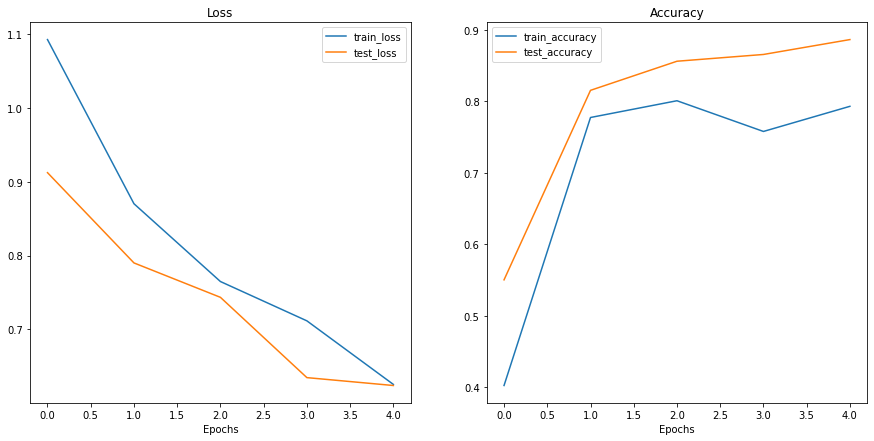

In [25]:
# Get the plot_loss_curves functions fro helper_functions.py
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

*Visualize, visualize, visualize!*

We'll need to make sure our images have:
- **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
- **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
- **Same device** - If our images are on a different device to our model, we'll get device errors.
- **Same transformations** - If our model is trained on images that have been transformed in certain way and we try and make predictions on images transformed in a different way, these predictions may be off.

To do all these processed, we'll create a function `pred_and_plot_image()`

In [26]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):

  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for image (if one doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

  ### Predcit on image

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation model and inference context manager
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to image
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilites
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilites -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot the image with prediction label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

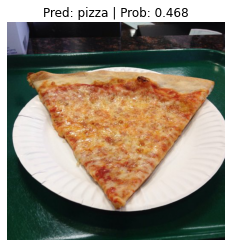

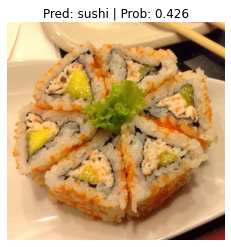

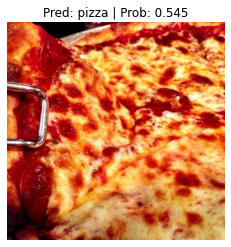

In [27]:
# Let's test it out by making predictions on a few random images from the test set.

# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(
      model=model,
      image_path=image_path,
      class_names=class_names,
      image_size=(224, 224)
  )

### 6.1 Making predictions on a custom image

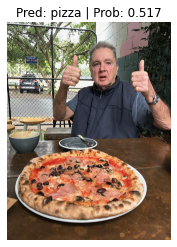

In [29]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(response.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Print on custom image
pred_and_plot_image(
    model=model,
    image_path=custom_image_path,
    class_names=class_names
)